<a href="https://colab.research.google.com/github/brock-ricker/Online-Shoppers-Purchasing-Intent/blob/main/Online_Shoppers_Purchasing_Intent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Online Shoppers Purchasing Intent
* Brock Ricker
* Last Update: 04/21/2022

In [157]:
#importing Modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Loading and Cleaning Data

In [158]:
#loading data from github
filepath = "https://raw.githubusercontent.com/brock-ricker/Online-Shoppers-Purchasing-Intent/main/online_shoppers_intention.csv"
df = pd.read_csv(filepath)

In [159]:
#checking data info
df.info()
# no missing columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [160]:
#Converting boolean columns into objects for modeling/graphing
df["Weekend"] = df["Weekend"].replace({True:"Yes",False:"No"})
df["Revenue"] = df["Revenue"].replace({True:"Yes",False:"No"})
df = df.astype({"Weekend" : object, "Revenue":object })


In [161]:
#Looking for data inconsistencies - objects
df_obj = df.select_dtypes(include = "object")
df_obj_cols = list(df_obj)
for col in df_obj_cols:
  print(f"{col}: {df_obj[col].unique()}\n")
#Looks OK

Month: ['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']

VisitorType: ['Returning_Visitor' 'New_Visitor' 'Other']

Weekend: ['No' 'Yes']

Revenue: ['No' 'Yes']



In [162]:
#Looking for data inconsistencies - numerical
df.describe()
#The column values make sense according to the data dictionairy

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


#Exploratory Data Analysis

In [163]:
#Lets create functions to plot distribution of all the features 
sns.set_context('talk')

#only distribtuion
def dist_plot (df,col):
  plt.figure(figsize = (10,6))
  plot_hist = sns.histplot(data = df, x = col, hue = "Revenue", multiple = "stack")
  plot_hist.set_title(f'Distribution of {col} vs. Revenue',fontsize = 18, fontweight='bold' )
  plot_hist.set_xlabel(col, fontsize = 18)
  plot_hist.set_ylabel('Count', fontsize = 18)


#only box
def box_plot (dj,col):
  plt.figure(figsize = (6,10))
  plot_box = sns.boxplot(data = df[col])
  plot_box.set_title(f'Distribution of {col}',fontsize = 18, fontweight='bold' )
  plot_box.set_xlabel(col, fontsize = 18)

#distribution + box
def plot (df,col):
  plt.figure(figsize = (20,10))
  plt.subplot(1,2,1)
  plt.title(f'Distribution of {col} vs. Revenue')
  sns.histplot(data = df, x = col, hue = "Revenue", multiple = "stack")

  plt.subplot(1,2,2)
  plt.title(f'Distribution of {col}')
  sns.boxplot(data = df[col])
  
  plt.show()

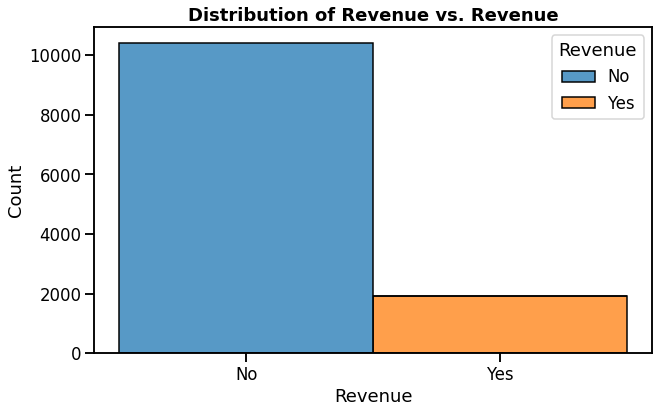

In [164]:
#Lets first plot the target column distribution
dist_plot(df,"Revenue")

This dataset is not well balanced, we will have to remember that when doing our modeling

In [165]:
#creating lists of feature columns to make plotting quickly easier
X = df.drop(columns="Revenue")
X_obj_cols = list(X.select_dtypes(include = "object"))
X_num_cols = list(X.select_dtypes(include = "number"))

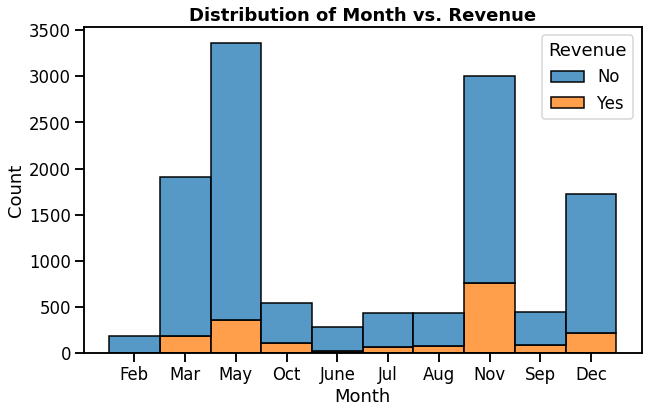

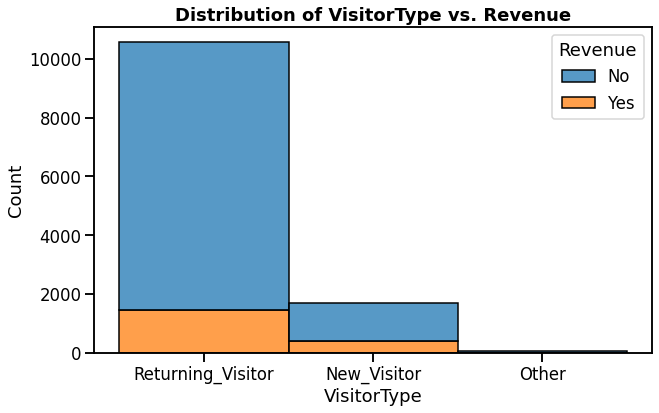

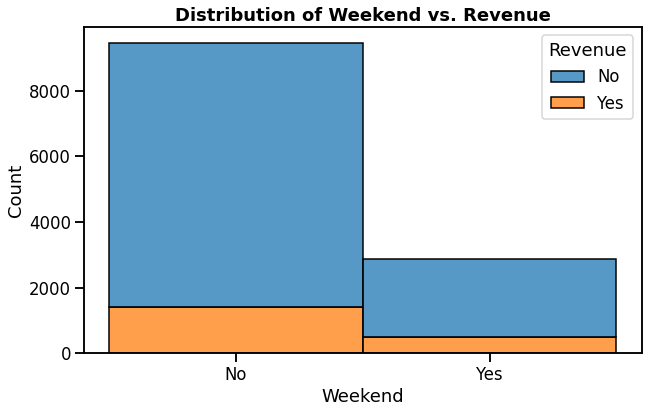

In [166]:
#plotting all object columns - box plot does not make sense in this case so I will do distribtuion only
for col in X_obj_cols:
  dist_plot(df,col)

There are no outliers in these columns. The distriburions are skewed toward certain values, but this makes sense in terms of:
* when people shop online (getting ready for summer, near christmas)
* people like to return to stores they like
* there are more weekdays than weekend days

In [197]:
#Looks like a majority of site visits are return customers - lets look at the numbers
df["VisitorType"].value_counts(normalize=True)

Returning_Visitor    0.855718
New_Visitor          0.137388
Other                0.006894
Name: VisitorType, dtype: float64

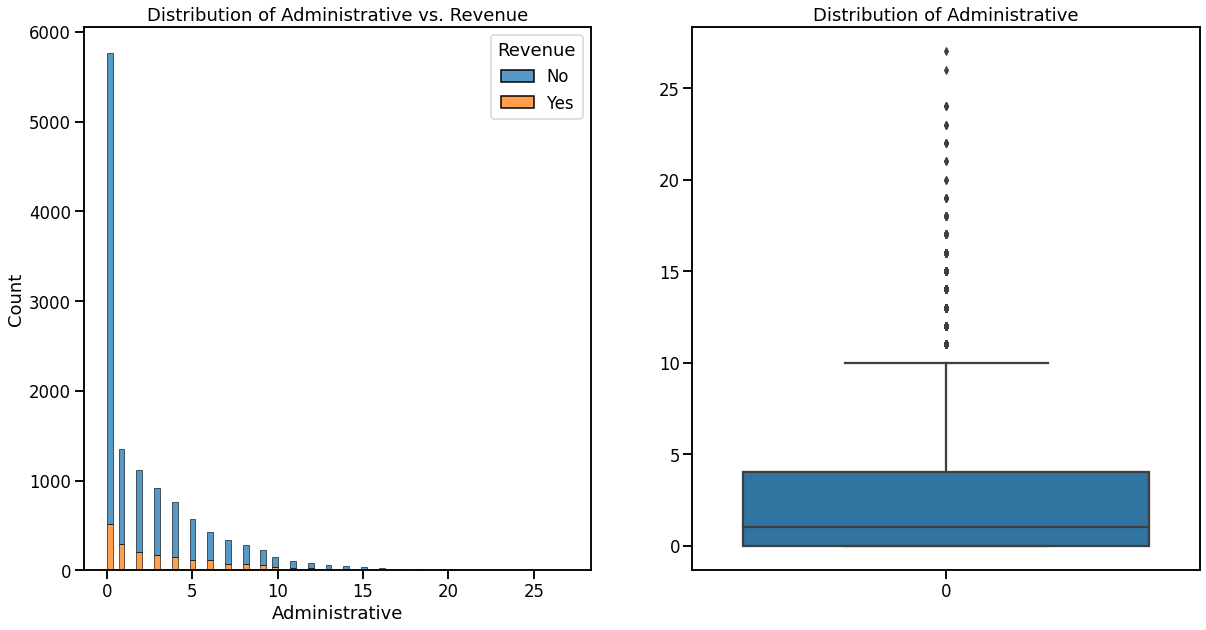

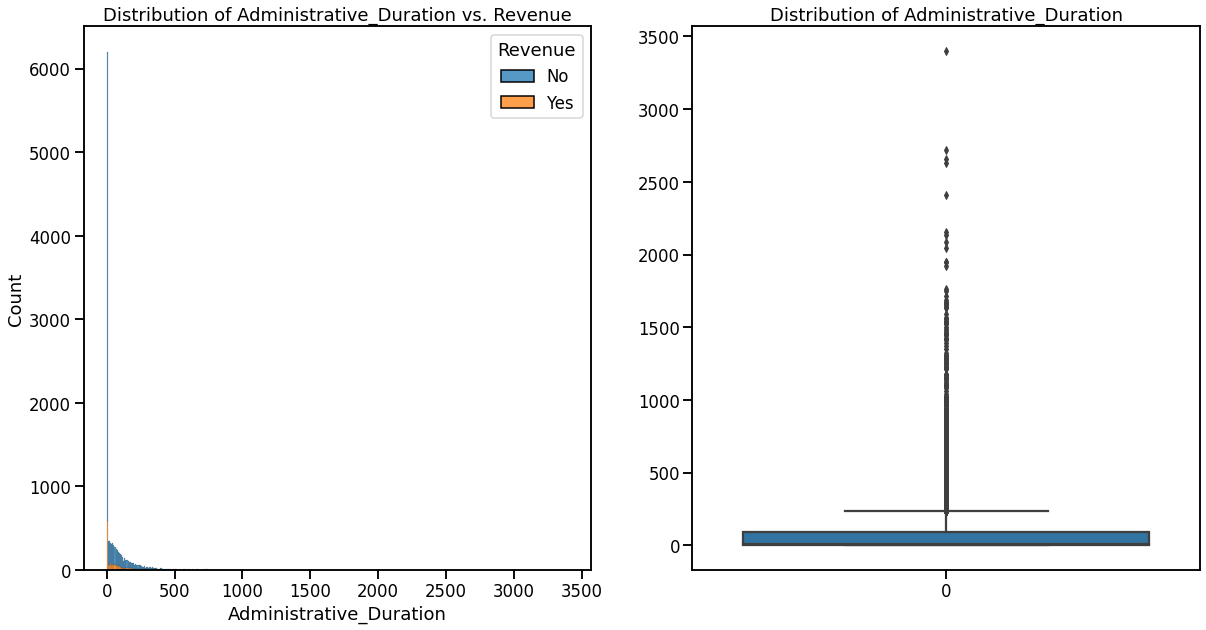

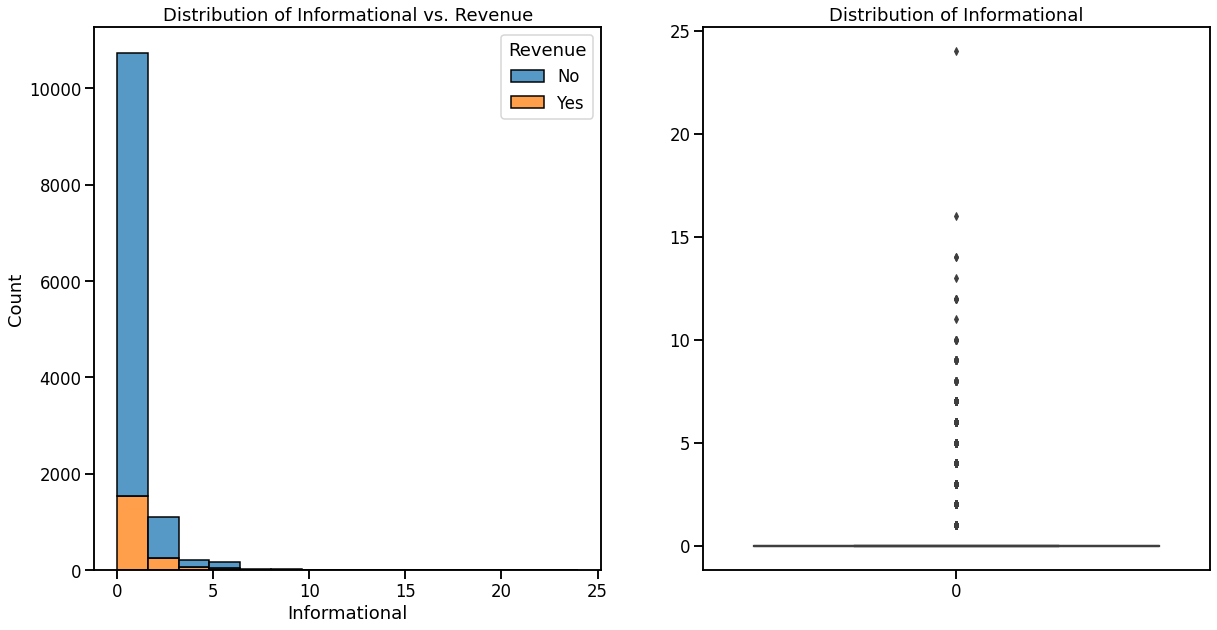

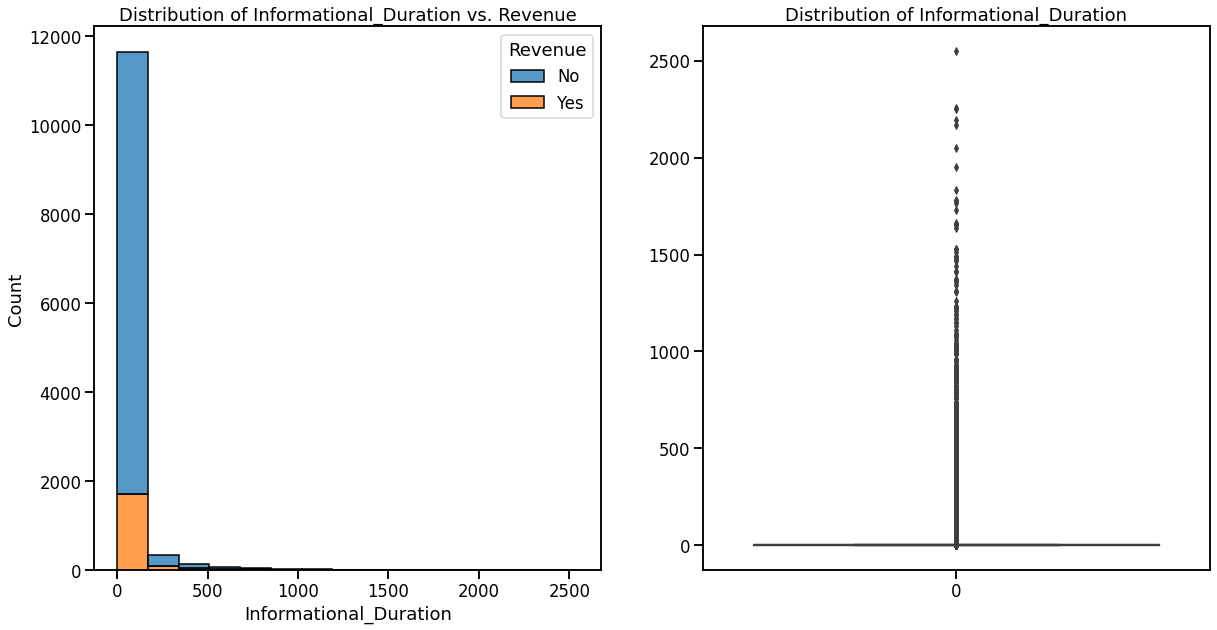

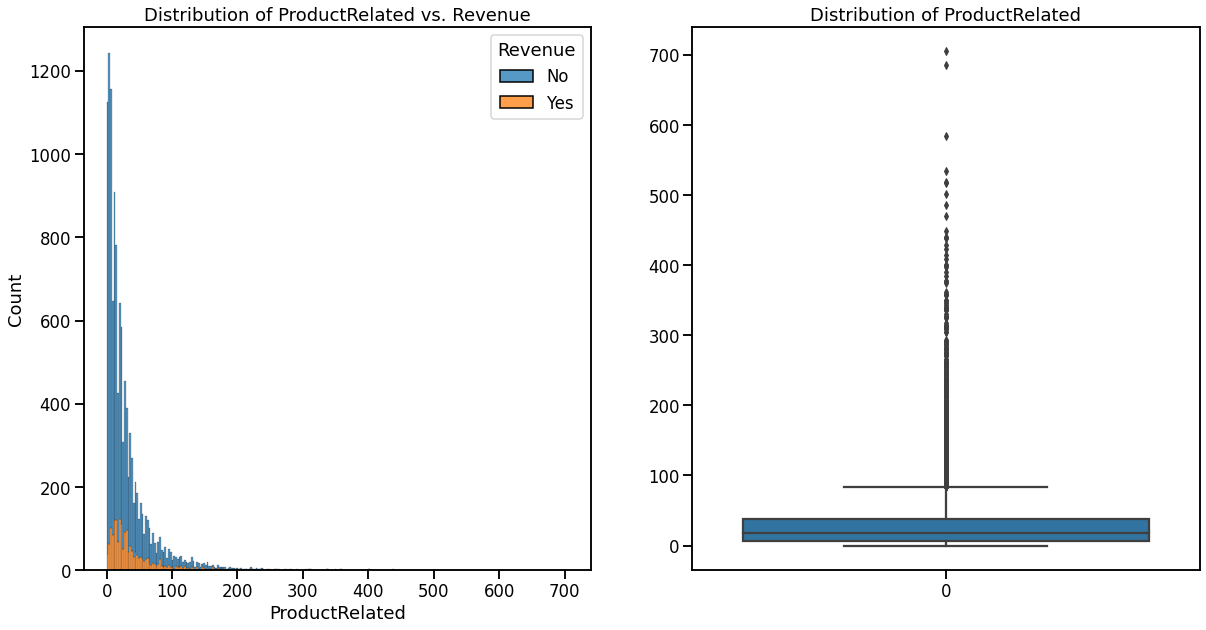

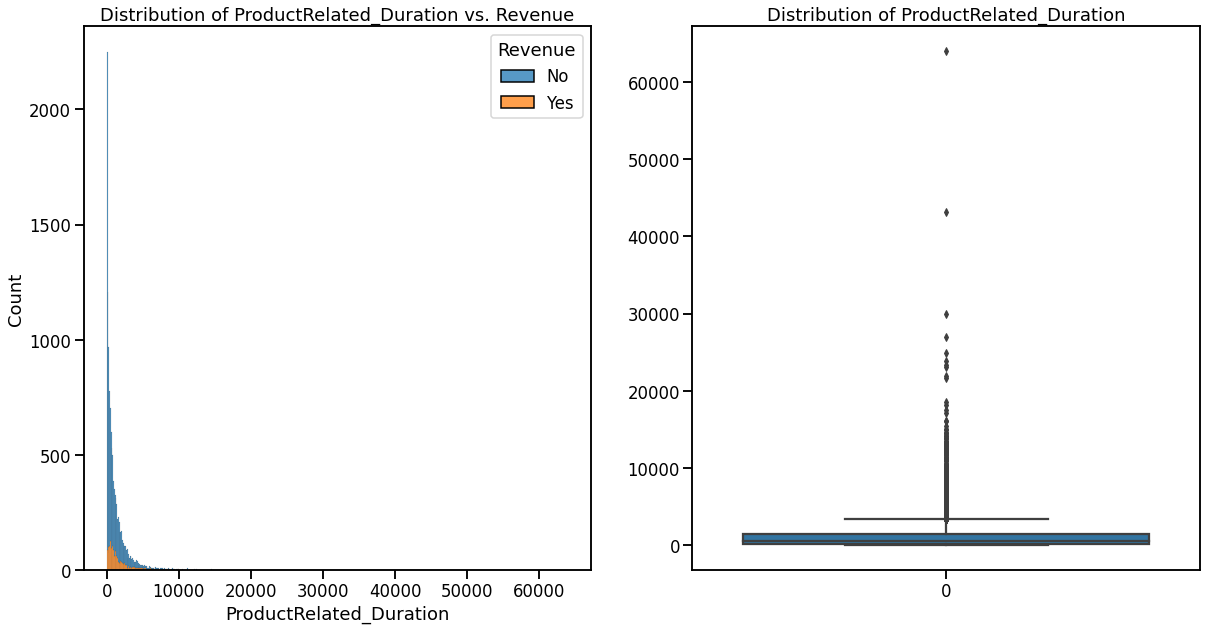

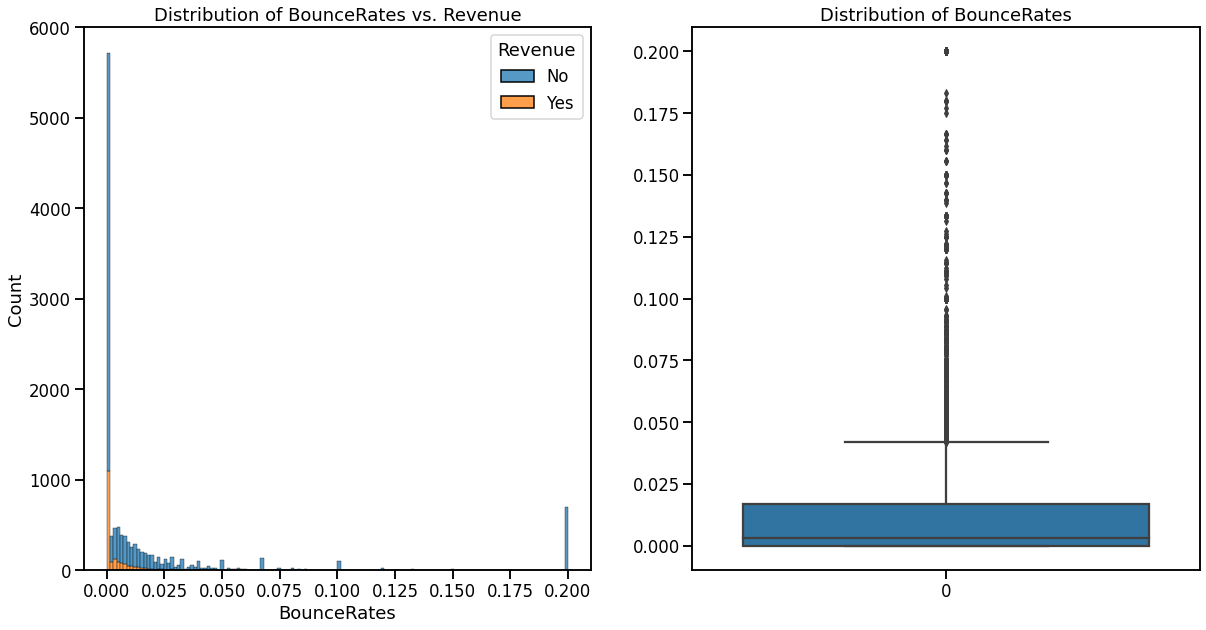

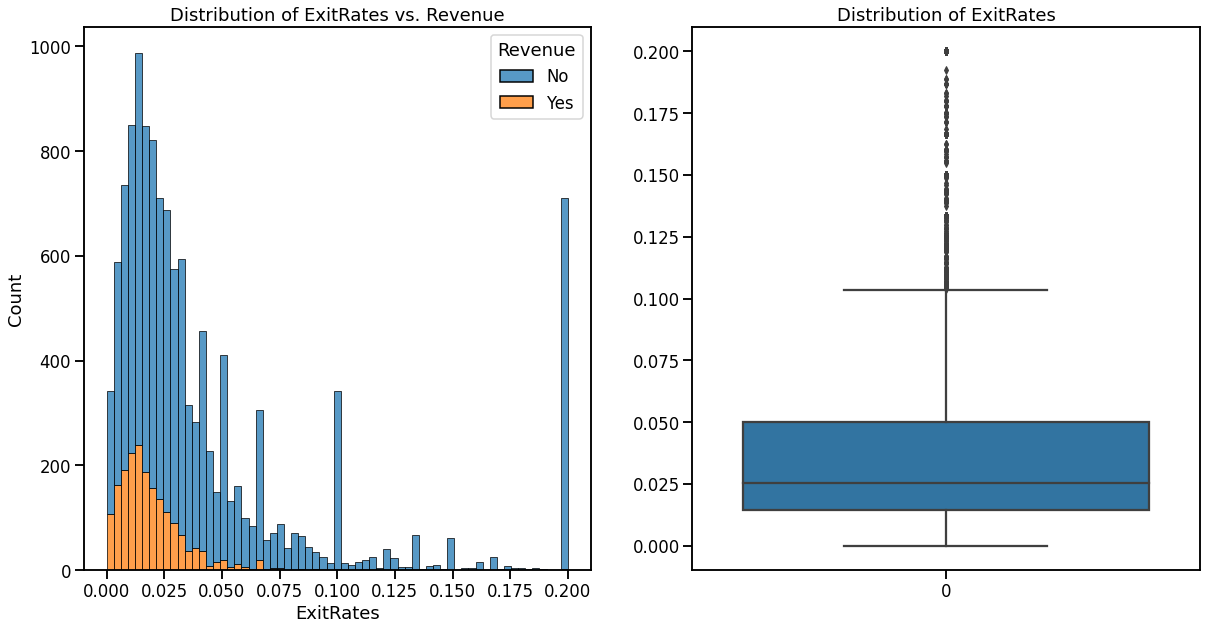

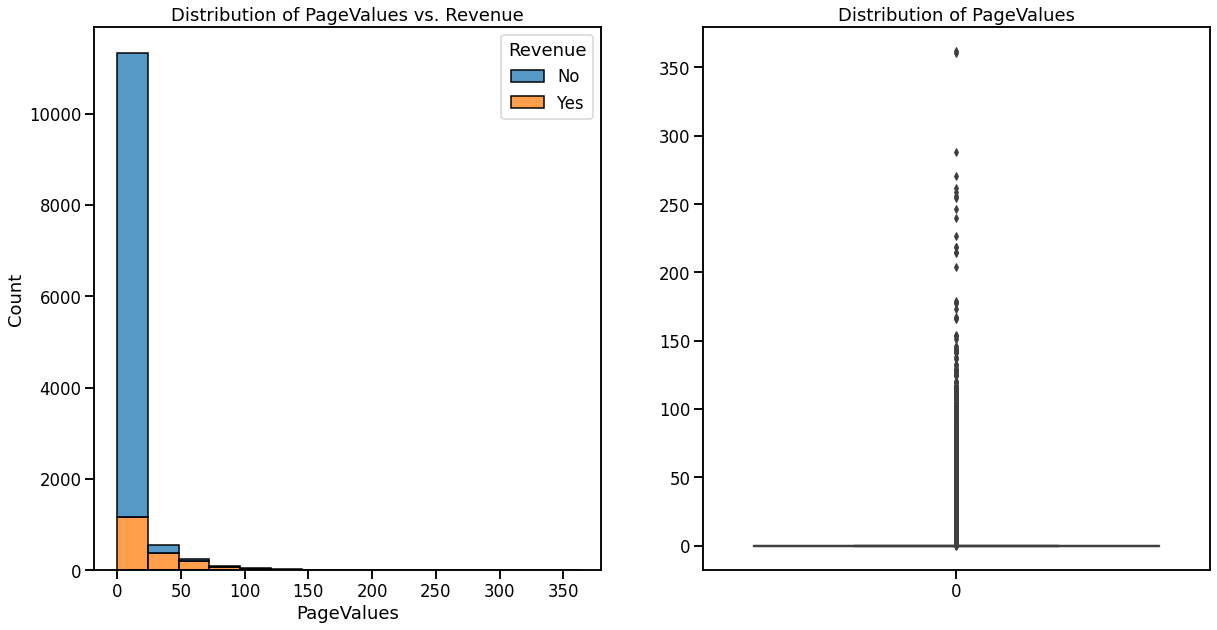

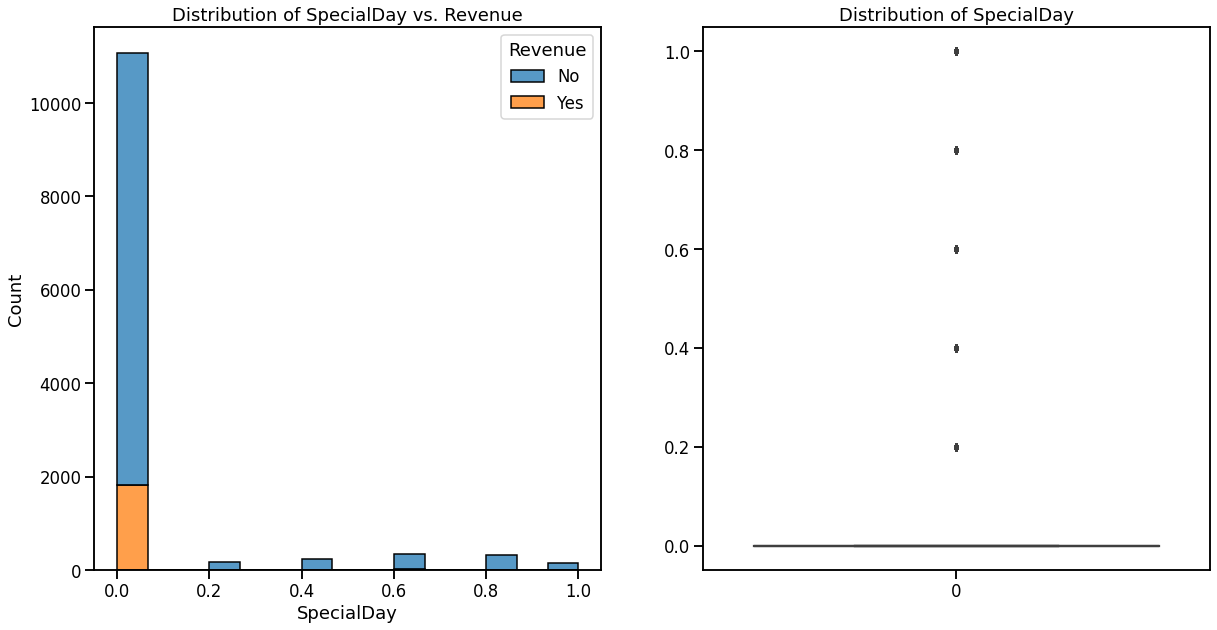

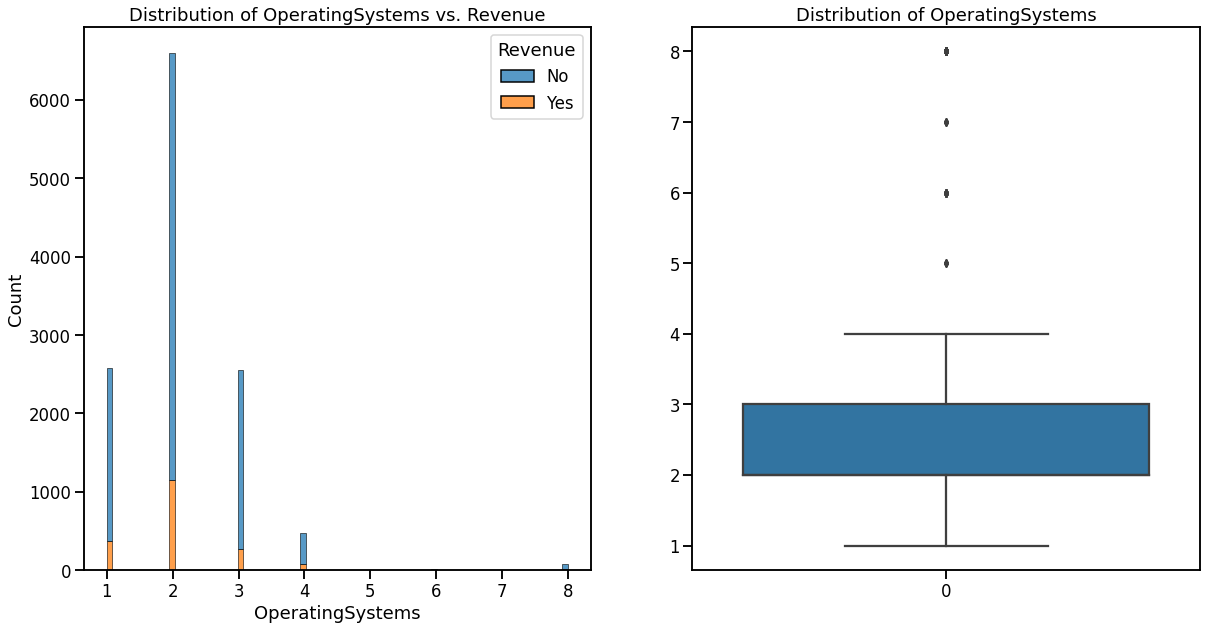

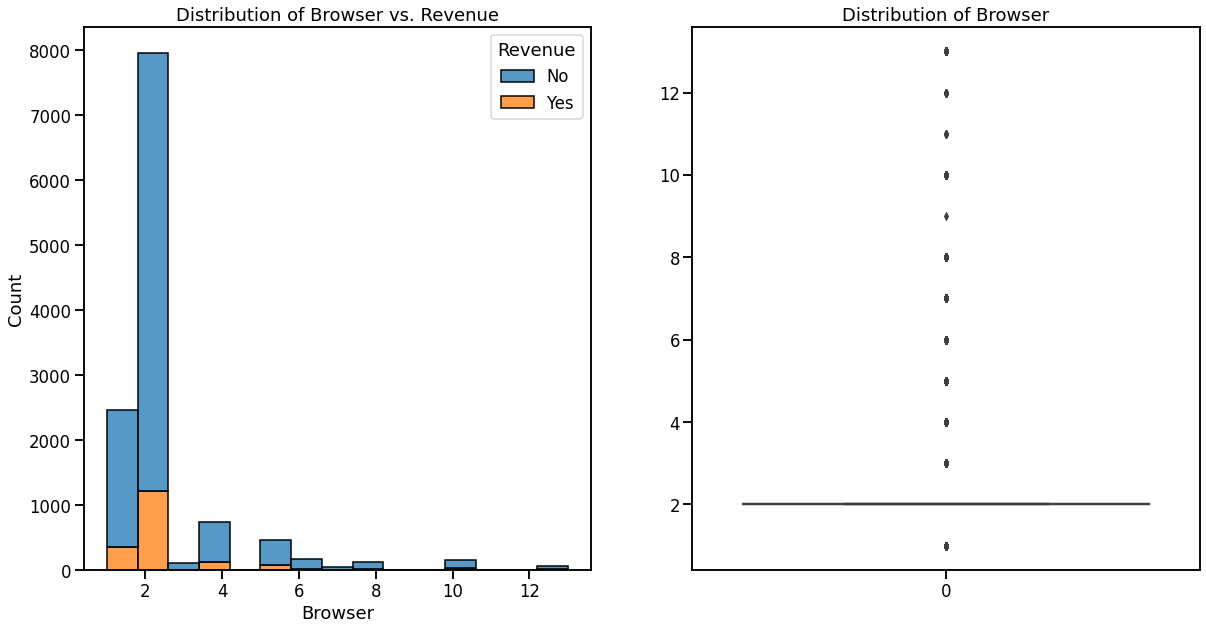

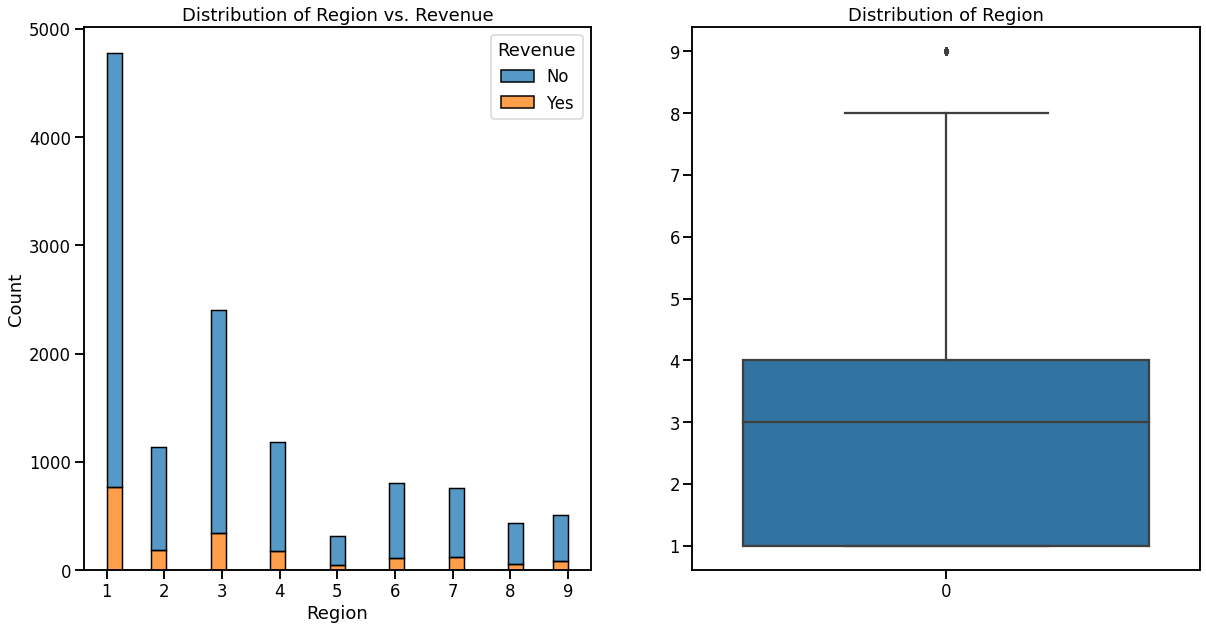

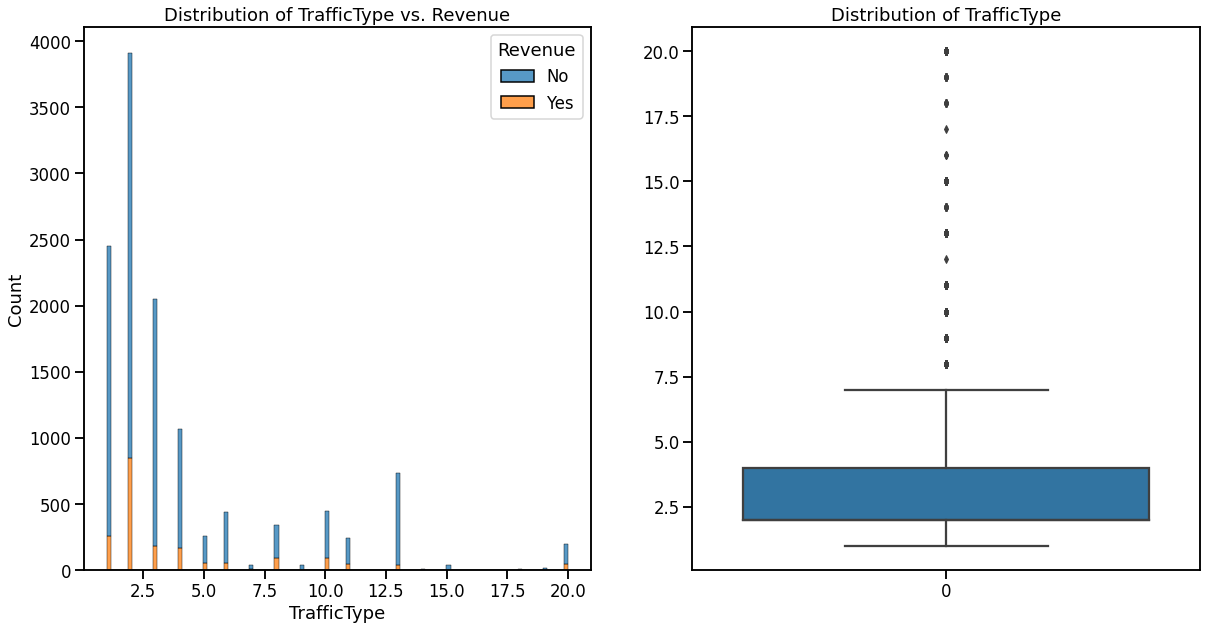

In [167]:
#plotting distribution of numerical columns
for col in X_num_cols:
  plot(df,col)

There are outliers in all columns, as shown by the boxplots. However, I do not think any of them are mistaken data entry, since the numeric summary I did earlier looks good. 

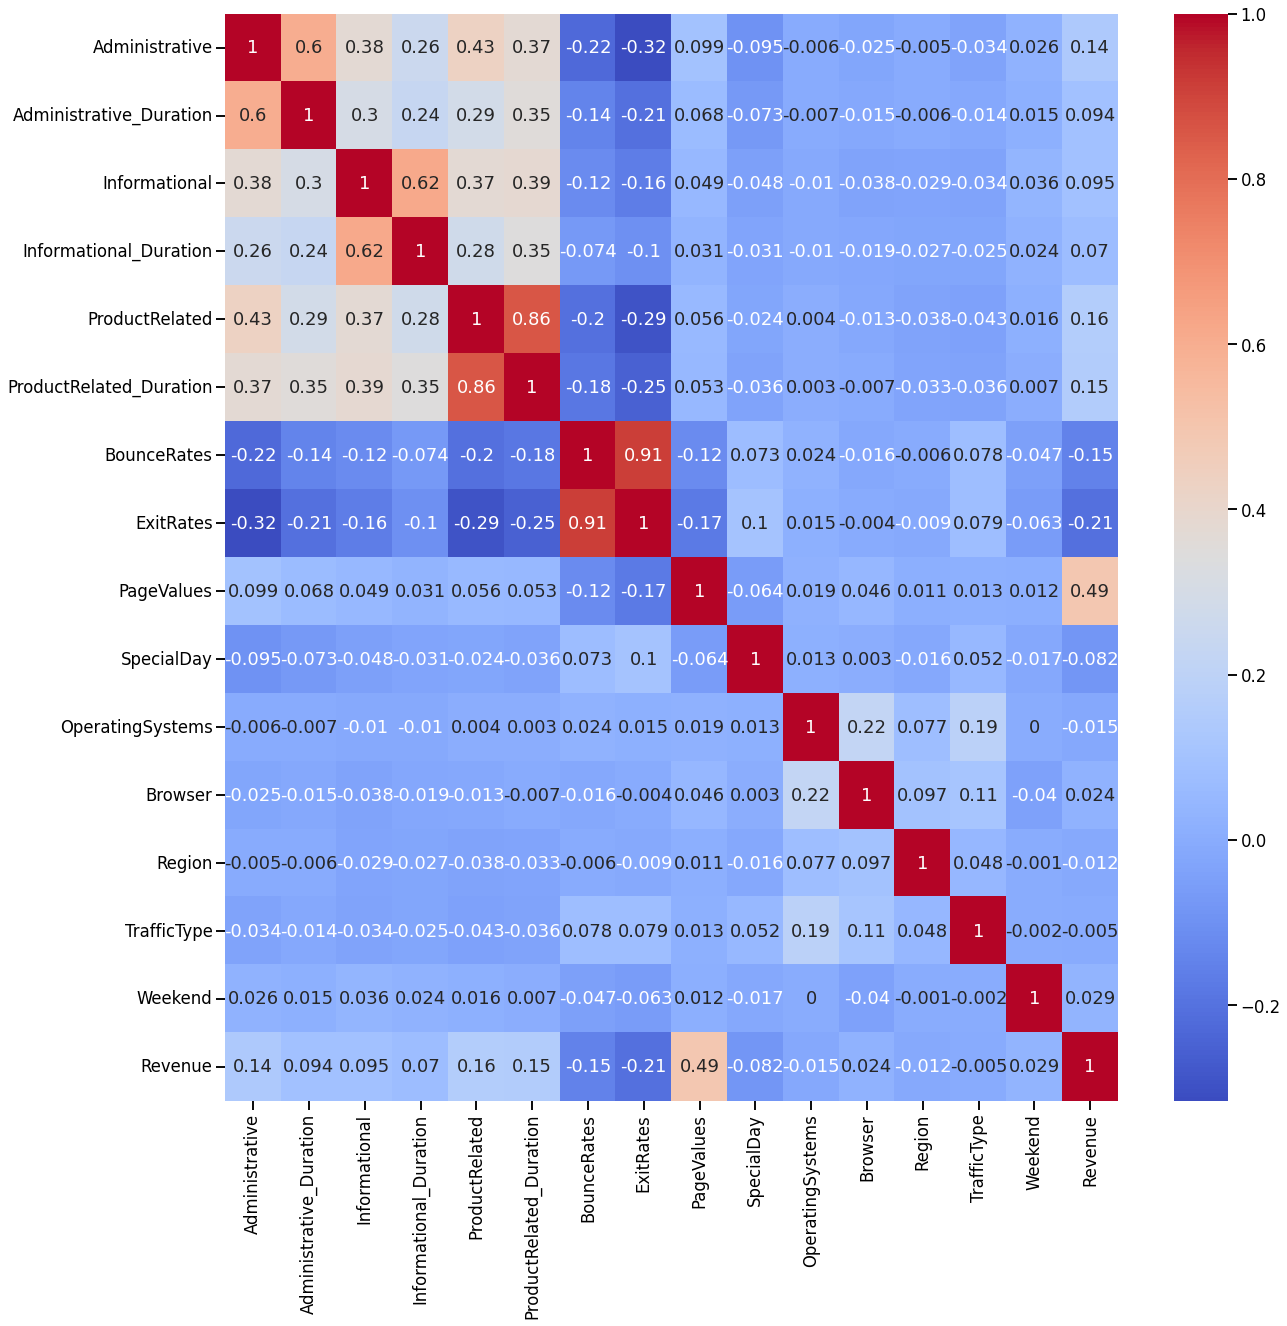

In [168]:
#Correlation Heatmap
#To get correlation with the target, I need to make the target column numeric. I will also do this with Weekend because it is simple yes/no column

df["Revenue"] = df["Revenue"].replace({"Yes":1,"No":0})
df = df.astype({"Revenue":int})
df["Weekend"] = df["Weekend"].replace({"Yes":1,"No":0})
df = df.astype({"Revenue":int})
plt.figure(figsize = (20,20))
corr = df.corr().round(3)
sns.heatmap(corr, cmap = "coolwarm", annot = True);

The three columns with the highest correlation with Revenue are:
* Page Values (positive/moderate)
* Exit Rate (negative/weak)
* Bounce Rates (negative/weak)

#Date Pre-processing

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [170]:
#Split into features/target
y = df["Revenue"]
X = df.drop(columns="Revenue")

In [171]:
#checking the balance of the target data set
y.value_counts(normalize=True)
#the revenue = yes values(1) are under-represented. I will have to over sample them.

0    0.845255
1    0.154745
Name: Revenue, dtype: float64

In [172]:
#oversampling Revenue = True data points
os = RandomOverSampler()
X_balanced, y_balanced = os.fit_resample(X,y)

In [173]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced,y_balanced,random_state=42)

In [174]:
#Create column transformer - for this I will need several tools, I will instantiate them here

#create column selectors
num_selector = make_column_selector(dtype_include="number")
cat_selector = make_column_selector(dtype_include="object")

#instantiate encoder
ohe = OneHotEncoder(sparse="False", handle_unknown="ignore")

#instantaite scaler
scaler = StandardScaler()

In [175]:
#make column transformer - not all model will need my data scaled, but it wont hurt so i will scale everything for simplicity

transformer = make_column_transformer((scaler,num_selector),(ohe,cat_selector),remainder = "passthrough")
transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f651a51d250>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse='False'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f651a51d490>)])

In [176]:
#transform data
X_train_processed = transformer.transform(X_train)
X_test_processed = transformer.transform(X_test)

In [177]:
#adding column names back onto data

#extracting columns names
cat_feature_names = transformer.named_transformers_["onehotencoder"].get_feature_names_out(cat_selector(X_train))
final_cols = num_selector(X_train) + list(cat_feature_names)

X_train_processed = pd.DataFrame(X_train_processed, columns = final_cols)
X_test_processed = pd.DataFrame(X_test_processed, columns = final_cols)


#Customer Segmentation

For my customer segmenation, I am going to use ALL columns including my target, because I want their likelihood to purchase to be part of the consideration. So for this I will need to create new versions of my data

In [178]:
#transforming data for use in clustering algorithm

transformer.fit(df)
df_clust = transformer.transform(df)

In [179]:
# Create function to calculate and plot the silhouette score and inertia of a KMeans model for various values of k

def plot_k_metrics (data,ks):

  sils = []
  inertias = []

  for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data)
    sils.append(silhouette_score(data,km.labels_))
    inertias.append(km.inertia_)

  fig, ax1 = plt.subplots(figsize=(9,7))
  ax1.set_xlabel("n clusters")
  ax1.set_ylabel("Inertia",color = "blue")
  ax1.plot(ks,inertias,color="blue", label = "inertia", marker="o")

  ax2 = ax1.twinx()

  ax2.set_ylabel("Silhouette Score",color="red")
  ax2.plot(ks, sils, color = "red",label="silhouette score",marker="+")
  ax1.legend(loc=0)
  ax2.legend(loc="upper left")
  plt.show()

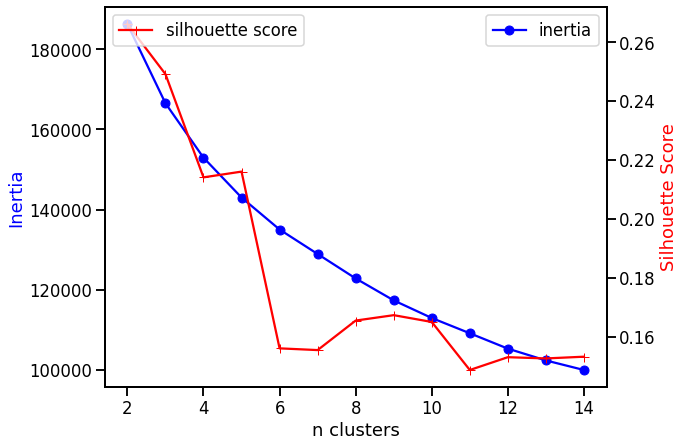

In [180]:
plot_k_metrics(df_clust,range(2,15))

based off of these scores, I think 5 clusters is optimal

In [181]:
#Creating Final clustering model using k=5
km_final = KMeans(n_clusters=5, random_state=42)
km_final.fit(df_clust)

KMeans(n_clusters=5, random_state=42)

In [182]:
#creating new data with clusters for analysis
 = df.copy()
df_w_clusters["cluster"] = km_final.labels_

In [184]:
#grouping by cluster
cluster_groups = df_w_clusters.groupby(by="cluster",as_index=False).mean()

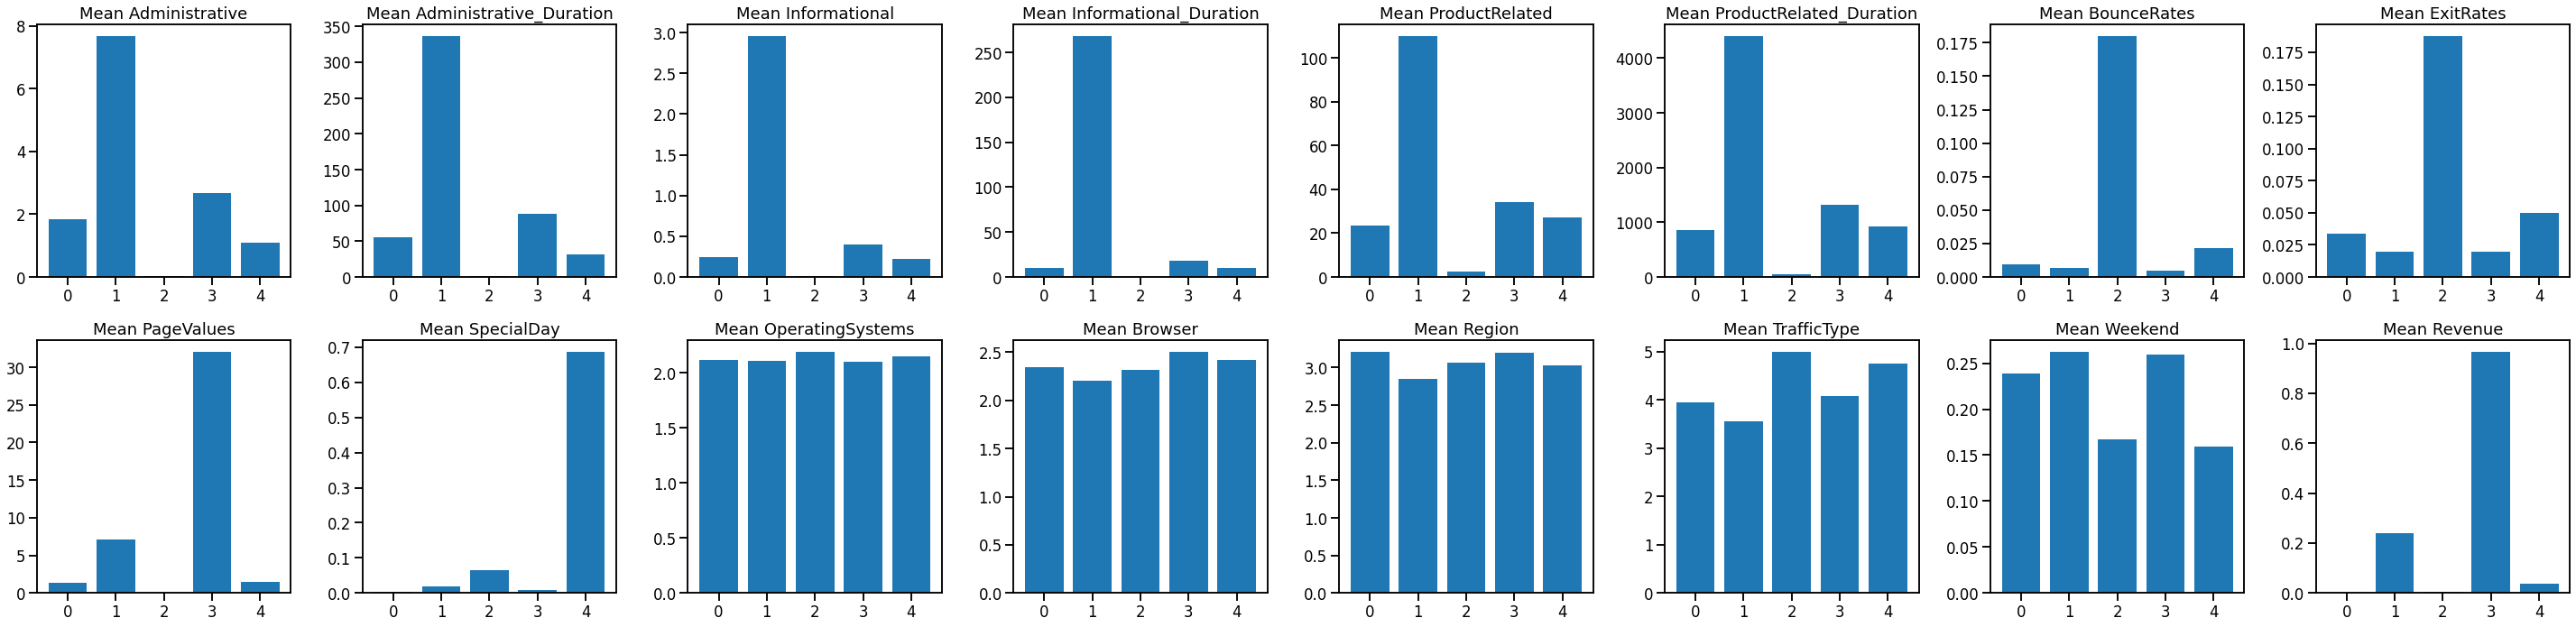

In [199]:
#visualize means
fig, axes = plt.subplots(2,8, figsize = (40, 10))

axes = axes.ravel()

for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')
  axes[i].set_xticks([0,1,2,3,4])
  plt.tight_layout()

In [193]:
#cluster group means raw data
cluster_groups.head()

,cluster,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue
0,0,1.848197,56.011586,0.246452,9.650710,23.459706,854.068359,0.009658,0.033735,1.332813,0.003385,2.120557,2.346439,3.206223,3.953131,0.238901,0.000000
1,1,7.675862,336.457064,2.956897,268.102688,109.890517,4400.456095,0.006559,0.019807,7.064489,0.017931,2.106034,2.206897,2.845690,3.550000,0.262069,0.237931
2,2,0.035126,1.270765,0.010977,0.037541,2.470911,43.048752,0.179913,0.187573,0.000000,0.065203,2.187706,2.315038,3.063666,4.993414,0.166850,0.004391
3,3,2.663840,88.198408,0.403392,18.555256,34.070866,1318.262273,0.004628,0.019388,32.009454,0.009085,2.103574,2.501514,3.195639,4.085403,0.259843,0.964870
4,4,1.096009,31.504900,0.226537,9.977903,27.055016,917.933471,0.021887,0.049737,1.439912,0.686300,2.148867,2.417476,3.033441,4.748652,0.159655,0.037756


In [194]:
#distribution plot function for groups
def dist_plot_clusters (df,col):
  plt.figure(figsize = (10,6))
  plot_hist = sns.histplot(data = df, x = col, hue = "cluster", multiple = "stack")
  plot_hist.set_title(f'Distribution of {col} vs. Cluster',fontsize = 18, fontweight='bold' )
  plot_hist.set_xlabel(col, fontsize = 18)
  plot_hist.set_ylabel('Count', fontsize = 18)

cluster_obj_cols = list(df_w_clusters.select_dtypes(include = "object"))

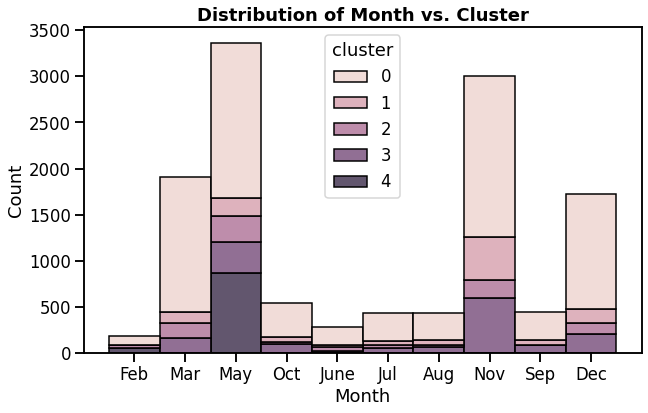

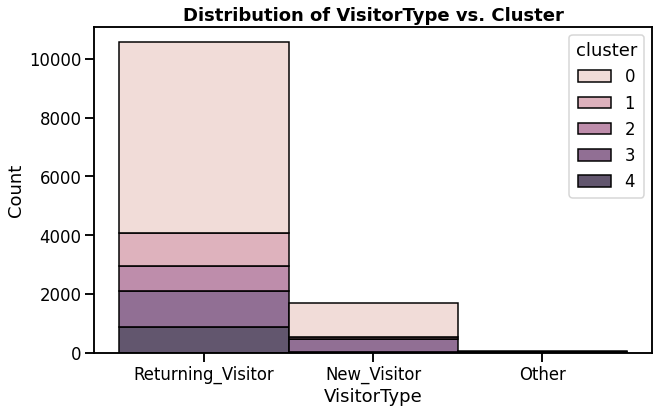

In [195]:
for col in cluster_obj_cols:
  dist_plot_clusters(df_w_clusters,col)

These are not very useful in my opinion